In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Steps and tasks:
1. Import the libraries, load dataset, print shape of data, visualize the images in dataset. (5 Marks)

2. Data Pre-processing: (15 Marks)
a. Normalization.
b. Gaussian Blurring.
c. Visualize data after pre-processing.

3. Make data compatible: (10 Marks)
a. Convert labels to one-hot-vectors.
b. Print the label for y_train[0].
c. Split the dataset into training, testing, and validation set.
(Hint: First split images and labels into training and testing set with test_size = 0.3. Then further split test data
into test and validation set with test_size = 0.5)
d. Check the shape of data, Reshape data into shapes compatible with Keras models if it’s not already. If it’s
already in the compatible shape, then comment in the notebook that it’s already in compatible shape.

4. Building CNN: (15 Marks)
a. Define layers.
b. Set optimizer and loss function. (Use Adam optimizer and categorical crossentropy.)

5. Fit and evaluate model and print confusion matrix. (10 Marks)

6. Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36],x_test[59]. (5 Marks)

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import sklearn.model_selection as sk
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from google.colab.patches import cv2_imshow

import numpy as np
import pandas as pd
import seaborn as sns
tf.__version__

'2.3.0'

In [ ]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
path_data ='/content/drive/My Drive/Colab Notebooks/images.npy'
x_data = np.load(path_data)

path_label ='/content/drive/My Drive/Colab Notebooks/Labels.csv'
y_data = pd.read_csv(path_label)


In [ ]:
print(f'x shape:{x_data.shape}')
print(f'y shape:{y_data.shape}')
y_data.value_counts()
# data distribution is skewed with bottom 3 at 1/3rd the top

x shape:(4750, 128, 128, 3)
y shape:(4750, 1)


Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
dtype: int64

In [ ]:
y_data = pd.get_dummies(y_data['Label'])
print(y_data.sum().T)


Black-grass                  263
Charlock                     390
Cleavers                     287
Common Chickweed             611
Common wheat                 221
Fat Hen                      475
Loose Silky-bent             654
Maize                        221
Scentless Mayweed            516
Shepherds Purse              231
Small-flowered Cranesbill    496
Sugar beet                   385
dtype: int64


In [ ]:
class_names =y_data.columns.to_list()

In [ ]:
y_data =y_data.to_numpy()

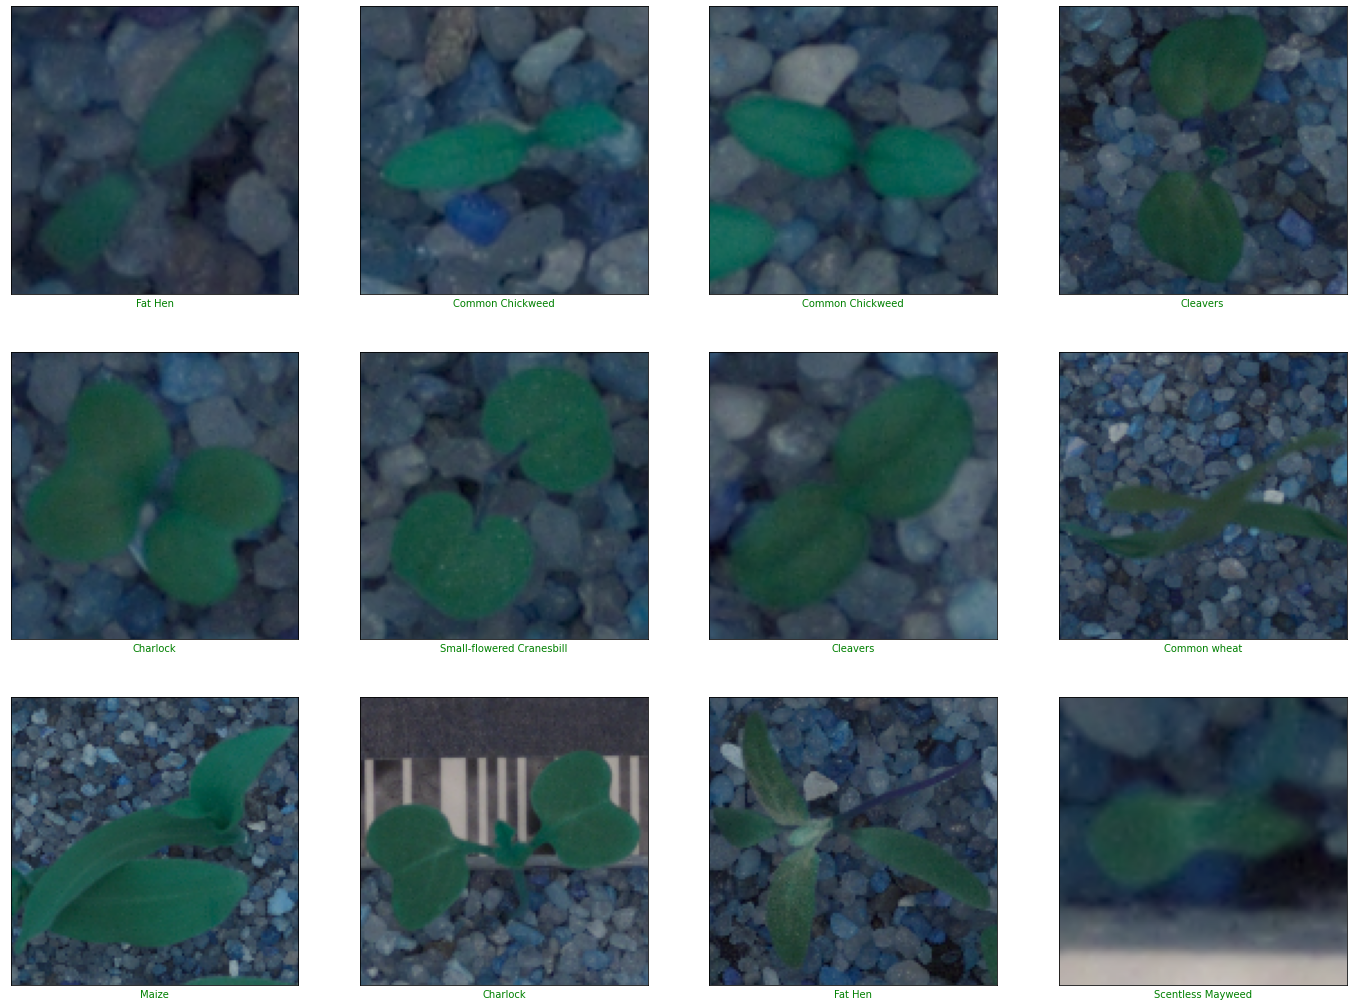

In [ ]:
## we will look at random images just to see what we are dealign with
def show_random_examples(x, x2, y, p , num):
    # x is the original image , x2 are modified image , num is the pulitple of 4 images to show y is teh actual , p is the prediction
    indices = np.random.choice(range(x.shape[0]), num*4 , replace=False)
    factor =2 
    # if modified images present then show them next to the original image otherwise just original images
    if x is x2:
      factor =1 
    x = x[indices]
    x2 = x2[indices]
    y = y[indices]
    p = p[indices]
    plt.figure(figsize=(num*8, num*6))
    for i in range(num*4):
        plt.subplot(num *factor, 4, factor*i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)

        if factor ==2:
          plt.subplot(num *2, 4, 2*i + 2)
          plt.imshow(x2[i])
          plt.xticks([])
          plt.yticks([])
          col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
          plt.xlabel(class_names[np.argmax(p[i])], color=col)



    plt.show()

show_random_examples(x_data, x_data,  y_data , y_data, 3)

In [ ]:
###now to split into train and test data
x_train, x_test, y_train, y_test = sk.train_test_split(x_data,y_data,test_size=0.3, random_state = 42)


In [ ]:
print( f' Train x:{x_train.shape} Train y:{y_train.shape}  ')
print( f' Test x:{x_test.shape} Test y:{y_test.shape}  ')
#If it’s already in the compatible shape, then comment in the notebook that it’s already in compatible shape.

 Train x:(3325, 128, 128, 3) Train y:(3325, 12)  
 Test x:(1425, 128, 128, 3) Test y:(1425, 12)  


In [ ]:
### function to Gausiaan blur
def do_gaussian_blur(x):
  new_set = []
  for i in x:
    new_set.append(cv2.GaussianBlur(i,(5,5),cv2.BORDER_DEFAULT))
  return np.array(new_set)



********* After Gaussian Blur *******


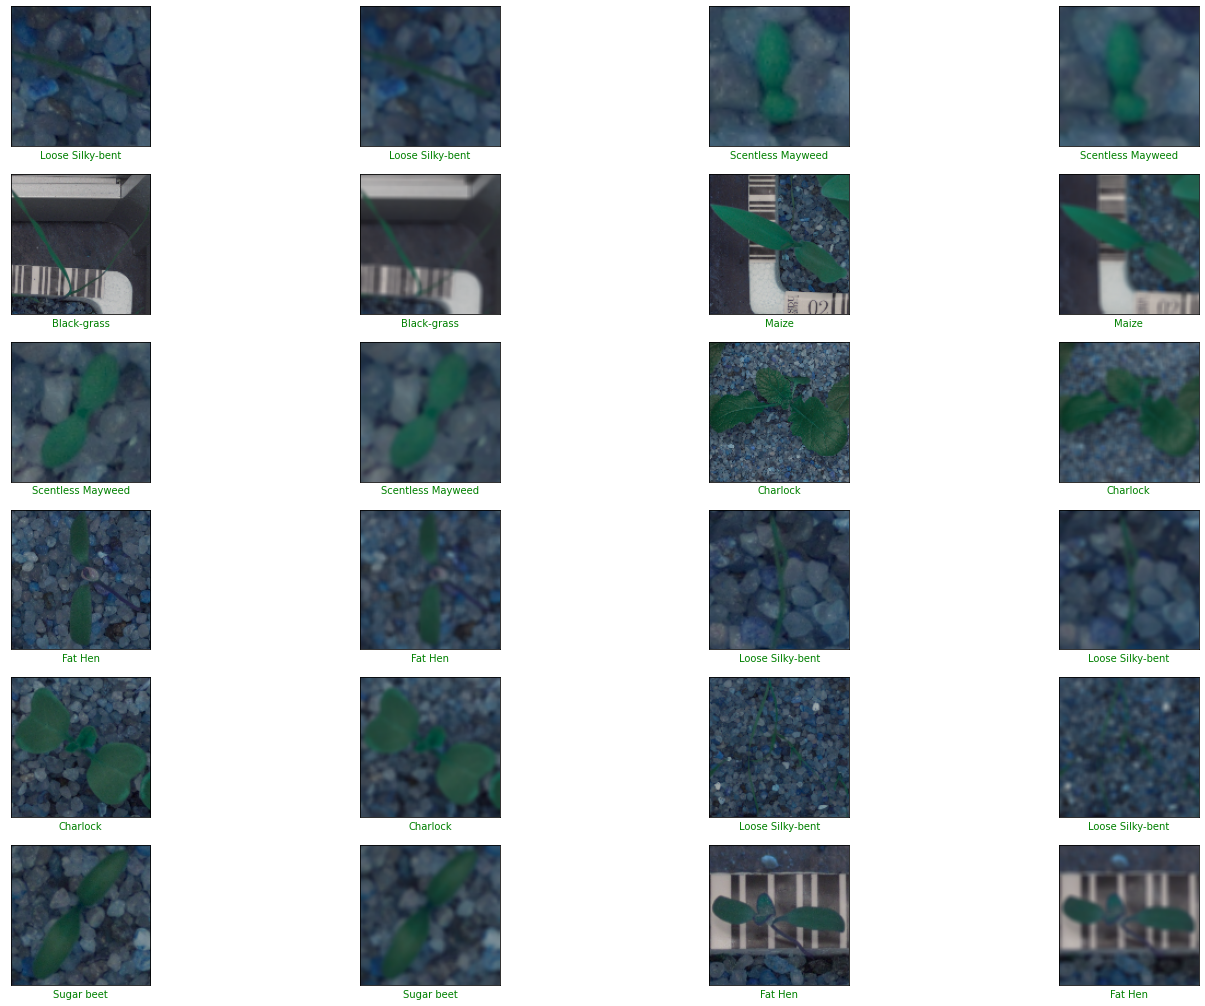

In [ ]:

x_test2 = do_gaussian_blur(x_test)
x_train2 = do_gaussian_blur(x_train)

print("********* After Gaussian Blur *******")
show_random_examples(x_train, x_train2,  y_train , y_train, 3)

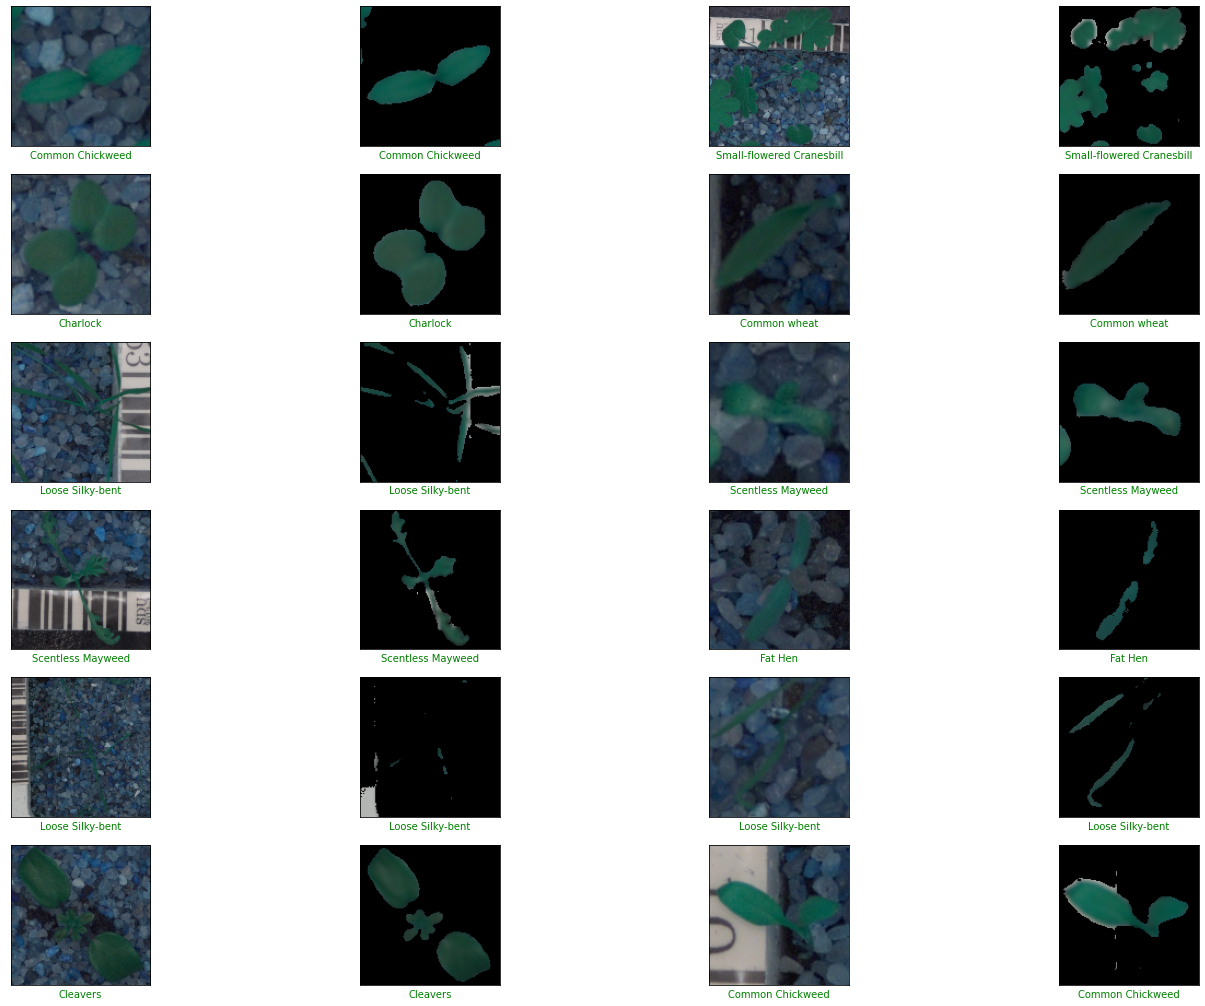

In [ ]:

### All teh seeds are Green - so maybe removing teh background is a good trick
### function to apply a green mask
### its easier to apply a greenish mask in HSV rather than in RGB


# I tried with both green_mask and without the green mask; the
# the results were better with the green mask always 

def do_green_mask(x):
  new_set = []
  for i in x:
    hsv = cv2.cvtColor(i, cv2.COLOR_BGR2HSV)
    # mask = cv2.inRange(hsv, (36, 0, 0), (70, 255,255))
    mask = cv2.inRange(hsv, (30, 0, 0), (75, 255,255))

    ## slice the green
    imask = mask>0  # filter
    green = np.zeros_like(i, np.uint8) # zeros
    green[imask] = i[imask]  # get back RGB  only for green cells
    new_set.append(green)
  return np.array(new_set)




x_test3 =do_green_mask(x_test2)
x_train3 = do_green_mask(x_train2)
show_random_examples(x_train, x_train3,  y_train , y_train, 3)

In [ ]:
#### Scale by 255
x_train5 = x_train3.astype('float32') # Conversion to float type from integer type.
x_test5 = x_test3.astype('float32')
x_train5 /= 255.0 # Division by 255
x_test5 /= 255.0

In [ ]:
print(f' x_train: {x_train[0][0][0]}')
print(f' x_train2: {x_train2[0][0][0]}')
print(f' x_train3: {x_train3[0][0][0]}')
print(f' x_train5: {x_train5[0][0][0]}')


 x_train: [122 117 121]
 x_train2: [163 155 155]
 x_train3: [0 0 0]
 x_train5: [0. 0. 0.]


In [ ]:
#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('seed_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)



In [ ]:
input_shape = (128,128,3)
print (input_shape)

(128, 128, 3)


In [ ]:
def conv_model(input_shape,classes):
  model = Sequential()
  model.add(Input(input_shape))

  model.add(Conv2D(128,(3,3),strides=(1,1)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3,3), padding="same")) 
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.25))

  
  model.add(Conv2D(32, (3,3), padding="same"))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  
  # Output Layer
  model.add(Flatten())
  model.add(Dense(128 , activation = 'relu'))
  model.add(Dense(64 , activation = 'relu'))
  model.add(Dense(classes,activation='softmax'))
  return model


model = conv_model(input_shape=input_shape,classes=12)

In [ ]:
# initiate Adam optimizer
base_learning_rate = 0.00001
opt = keras.optimizers.Adam(learning_rate=base_learning_rate)


In [ ]:

# Let's train the model
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 128)     3584      
_________________________________________________________________
activation (Activation)      (None, 126, 126, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 64)        73792     
_________________________________________________________________
activation_1 (Activation)    (None, 63, 63, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0

In [ ]:
epochs = 125
history = model.fit(x_train5, y_train,
          batch_size=12 ,
          epochs=epochs,
          validation_split=0.4,
          shuffle=True,
          verbose=1,
          callbacks=[early_stopping,model_checkpoint])

Epoch 1/125
167/167 [==============================] - ETA: 0s - loss: 2.4384 - accuracy: 0.1504
Epoch 00001: val_loss improved from inf to 2.46818, saving model to seed_cnn_checkpoint_01_loss2.4682.h5
167/167 [==============================] - 4s 21ms/step - loss: 2.4384 - accuracy: 0.1504 - val_loss: 2.4682 - val_accuracy: 0.2361
Epoch 2/125
167/167 [==============================] - ETA: 0s - loss: 2.1897 - accuracy: 0.2852
Epoch 00002: val_loss improved from 2.46818 to 2.40424, saving model to seed_cnn_checkpoint_02_loss2.4042.h5
167/167 [==============================] - 3s 19ms/step - loss: 2.1897 - accuracy: 0.2852 - val_loss: 2.4042 - val_accuracy: 0.2135
Epoch 3/125
166/167 [============================>.] - ETA: 0s - loss: 2.0021 - accuracy: 0.3494
Epoch 00003: val_loss improved from 2.40424 to 2.25572, saving model to seed_cnn_checkpoint_03_loss2.2557.h5
167/167 [==============================] - 3s 19ms/step - loss: 2.0018 - accuracy: 0.3494 - val_loss: 2.2557 - val_accurac

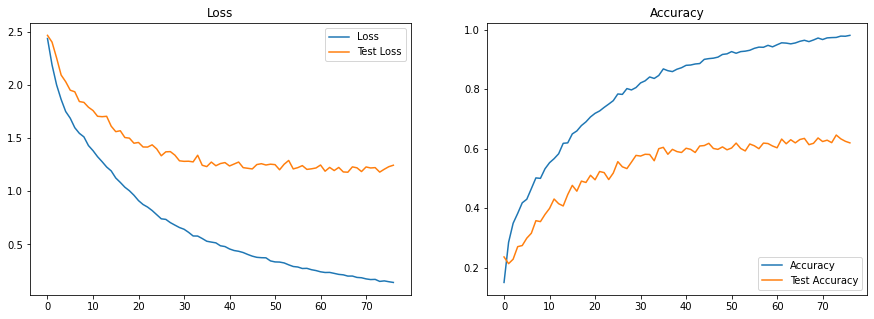

In [ ]:
def show_final_history(history):
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title("Loss")
    ax[1].set_title("Accuracy")
    ax[0].plot(history.history["loss"],label="Loss")
    ax[0].plot(history.history["val_loss"],label="Test Loss")
    ax[1].plot(history.history["accuracy"],label="Accuracy")
    ax[1].plot(history.history["val_accuracy"],label="Test Accuracy")
    ax[0].legend(loc="upper right")
    ax[1].legend(loc="lower right")

show_final_history(history)


In [ ]:
##### confusion matrix 
from sklearn.metrics import classification_report,confusion_matrix
y_pred = model.predict(x_test5)
valid_preds = np.argmax(y_pred, axis = 1) 
y_check = np.argmax(y_test, axis = 1) 
cnf_matrix = confusion_matrix(y_check, valid_preds)

[(0, 'Black-grass'), (1, 'Charlock'), (2, 'Cleavers'), (3, 'Common Chickweed'), (4, 'Common wheat'), (5, 'Fat Hen'), (6, 'Loose Silky-bent'), (7, 'Maize'), (8, 'Scentless Mayweed'), (9, 'Shepherds Purse'), (10, 'Small-flowered Cranesbill'), (11, 'Sugar beet')]


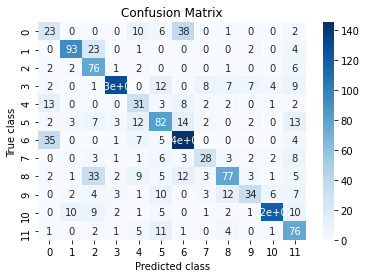

In [ ]:
print ( list(enumerate(class_names)))
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Blues, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')#
plt.show()

## so you can see
## Charloc/CLeavers -  often gets misclassified
## Black grass and Loose Silky-bent gets misclassified

In [ ]:
# Score trained model.
scores = model.evaluate(x_test5, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

45/45 [==============================] - 0s 11ms/step - loss: 1.1175 - accuracy: 0.6407
Test loss: 1.1175469160079956
Test accuracy: 0.6407017707824707


<function matplotlib.pyplot.show>

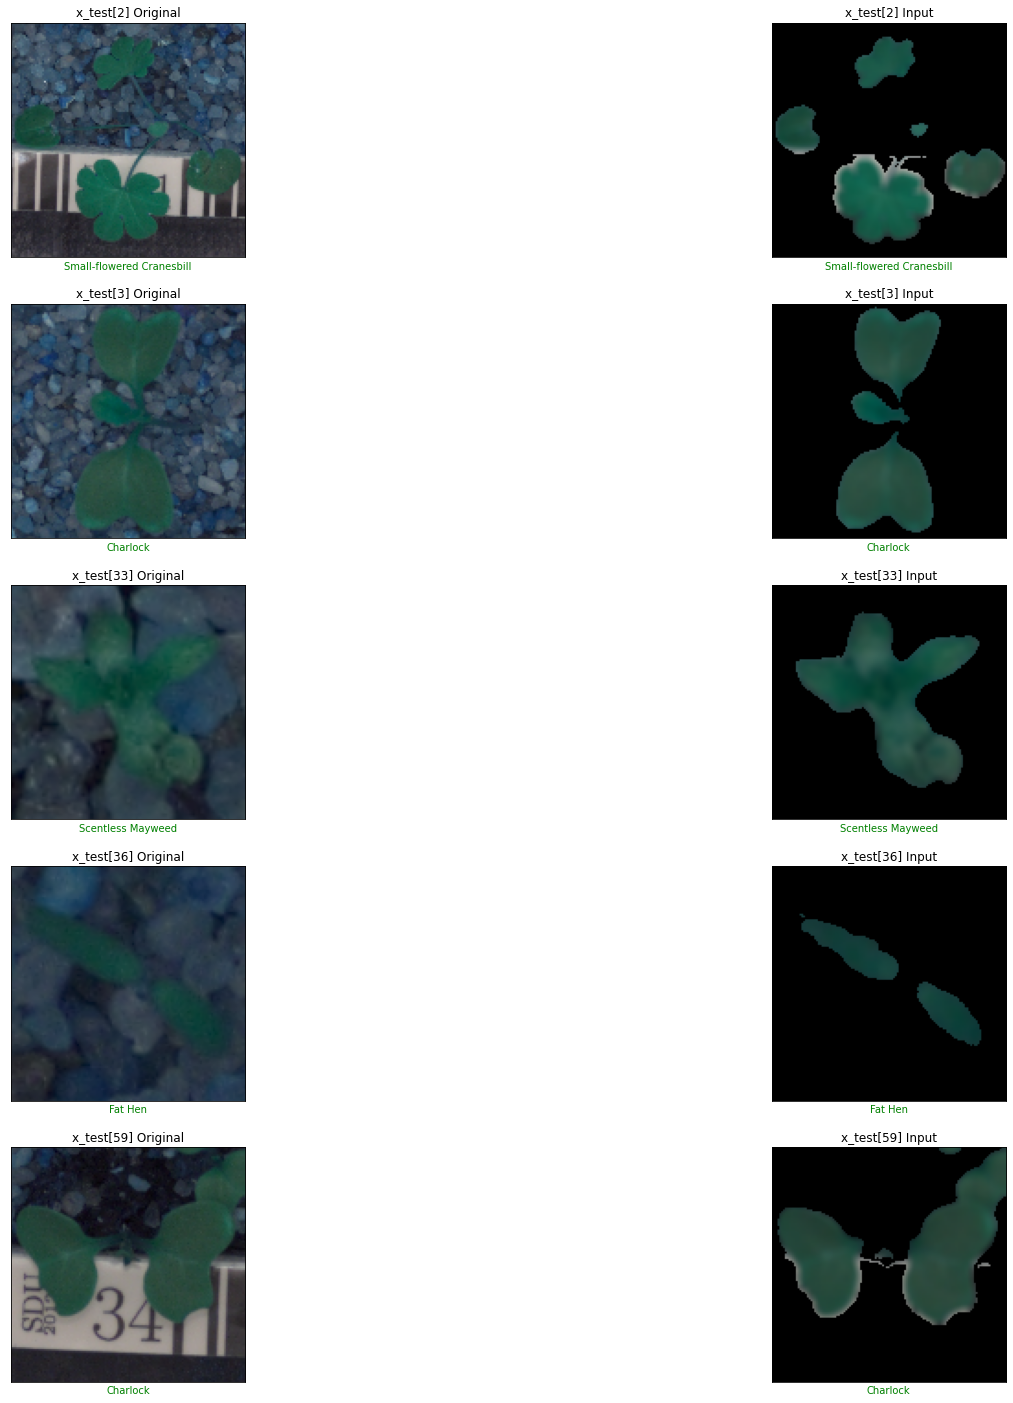

In [ ]:
#Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36],x_test[59]. (5 Marks)
index = [2,3,33,36,59]
j = 0
plt.figure(figsize=(25,25))
for i in index:
  plt.subplot(len(index) , 2, 2*j + 1)
  plt.imshow(x_test[i])
  plt.xticks([])
  plt.yticks([])
  plt.title("x_test[" + str(i) +"] Original")
  col = 'green' if np.argmax(y_pred[i]) == np.argmax(y_test[i]) else 'red'
  plt.xlabel(class_names[np.argmax(y_test[i])], color=col)

  plt.subplot(len(index) , 2, 2*j + 2)
  plt.imshow(x_test5[i])
  plt.xticks([])
  plt.yticks([])
  plt.title("x_test[" + str(i) +"] Input")
  col = 'green' if np.argmax(y_pred[i]) == np.argmax(y_test[i]) else 'red'
  plt.xlabel(class_names[np.argmax(y_pred[i])], color=col)

  j = j +1
plt.show
